## WHAT IS TORCH.NN REALLY?

Pytorch provides elegantly designed modules and classes like torch.nn, torch.optim, Dataset and Dataloader which makes creating and training neural networks much simpler. In order to fully utilize thier potential and customize them as per your requirements we need to understand what each piece actually does. We will start out by creating our models from scratch using only pytorch's basic tensor functionality. Then incrementally moodify our code by adding features from torch.nn, torch.optim, Dataset and Dataloader one by one, showing exactly what each piece does. This will make our code more flexible and concise.

We will use MNIST as our dataset, which consists of greyscale images of handwritten digits. The images have a resolution of 28 x 28. We will make use of pathlib to deal with paths and download our dataset using requests module. We will import packages only when required.

In [13]:
from pathlib import Path
import requests

WORK_DIR = Path('D:/work/workspace/machine_learning/Datasets')
DATA_PATH = WORK_DIR / 'MNIST'

# create data directory
DATA_PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

# check if file is already downloaded or not 
if not (DATA_PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (DATA_PATH/FILENAME).open('wb').write(content)

**Note:** Write constant variables with caps

Here the data exists in the form of numpy arrays, and has been saved using pickle, a python specific-format for serializing data.

In [14]:
import gzip # the data is zipped
import pickle # to load the pickle data

# as_posix give the str representation of path
with gzip.open((DATA_PATH/FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_val, y_val), _) = pickle.load(f, encoding='latin-1')

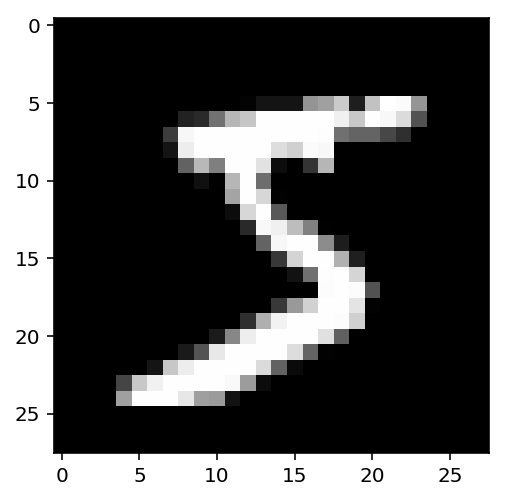

(50000, 784)


In [15]:
# check if data loaded properly 
import numpy as np 
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# reshape the images, currenlty flattened to 784 (28 x 28)
plt.imshow(x_train[0].reshape(28, 28), cmap='Greys_r')
plt.show()
print(x_train.shape)

In [16]:
# convert data to tensors
import torch

# torch.tensor(np.array) assigns the dtype automatically
x_train, y_train, x_val, y_val = map(torch.tensor, (x_train, y_train, x_val, y_val))
n, c = x_train.shape
print(x_train.shape)
print(x_val.shape)

torch.Size([50000, 784])
torch.Size([10000, 784])


## Neural net from scratch (no torch.nn)

requires_grad: tells torch to record all operations perfomed on that tensor, so we can get the gradients during back-prop automatically For the weights we specify requires_grad=True after initialization, beacuse we don't want that step included for back-prop.

For the weight initialization we use Xavier Initialization (multiply the weights by 1/sqrt(n)), where n #of input units

In [17]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_() # in_place, don't want initialization step to be accounted for back_prop
bias = torch.zeros(10, requires_grad=True)

Since Pytorch provides the functionality that calculated gradients automatically we can use any function or callable object as our model. Although pytorch has a lot of pre-defined activation and loss functions, we can easily create our own using python functions. Torch will automatically create fast GPU or vectorized CPU code for the model.

In [18]:
def model(xb):
    return log_softmax(xb @ weights + bias)

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

In the above, the @ stands for the dot product operation. We will call our function on one batch of data (in this case, 64 images). This is one forward pass.

In [19]:
bs = 64

xb = x_train[0:bs]
preds = model(xb) 
preds.shape

torch.Size([64, 10])

Let’s implement negative log-likelihood to use as the loss function (again, we can just use standard Python)

In [20]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.

In [21]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3587, grad_fn=<NegBackward>)


Let’s also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [22]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

Let’s check the accuracy of our random model, so we can see if our accuracy improves as our loss improves.

In [23]:
print(accuracy(preds, yb))

tensor(0.0469)


In [24]:
lr = 0.03
epochs= 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

In [25]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.7467, grad_fn=<NegBackward>) tensor(0.8750)


# Using torch.nn.functional
We will now refactor our code, so that it does the same thing as before, only we’ll start taking advantage of PyTorch’s nn classes to make it more concise and flexible. At each step from here, we should be making our code one or more of: shorter, more understandable, and/or more flexible.

In [26]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias  

Note that we no longer call log_softmax in the model function. Let’s confirm that our loss and accuracy are the same as before:

In [27]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.7467, grad_fn=<NllLossBackward>) tensor(0.8750)


# Refactor using nn.Module
Next up, we’ll use nn.Module and nn.Parameter, for a clearer and more concise training loop. We subclass nn.Module (which itself is a class and able to keep track of state). In this case, we want to create a class that holds our weights, bias, and method for the forward step. nn.Module has a number of attributes and methods (such as .parameters() and .zero_grad()) which we will be using.

nn.Parameter(): wraps around a tensor requiring auto_grad to make it a model parameter to be updated
nn.Module: inheriting into a class makes the class keep track of weights, layers and the forward step

In [37]:
from torch import nn


class Mnist_Logistic(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(784, 10))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weight + self.bias

Since we’re now using an object instead of just using a function, we first have to instantiate our model:

In [38]:
model = Mnist_Logistic()

Now we can calculate the loss in the same way as before. Note that nn.Module objects are used as if they are functions (i.e they are callable), but behind the scenes Pytorch will call our forward method automatically.

In [39]:
print(loss_func(model(xb), yb))

tensor(9.4556, grad_fn=<NllLossBackward>)


Now we can take advantage of model.parameters() and model.zero_grad() (which are both defined by PyTorch for nn.Module) to make those steps more concise and less prone to the error of forgetting some of our parameters, particularly if we had a more complicated model:

`with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr
        model.zero_grad()`

We’ll wrap our little training loop in a fit function so we can run it again later.

In [42]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                    model.zero_grad()
                    
fit()

Let’s double-check that our loss has gone down:

In [43]:
print(loss_func(model(xb), yb))

tensor(1.9430, grad_fn=<NllLossBackward>)


# Refactor using nn.Linear
We continue to refactor our code. Instead of manually defining and initializing self.weights and self.bias, and calculating xb  @ self.weights + self.bias, we will instead use the Pytorch class nn.Linear for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.

In [44]:
class Mnist_Logistic(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.fc(xb)

We instantiate our model and calculate the loss in the same way as before:

In [45]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2830, grad_fn=<NllLossBackward>)


Refactor using optim
Pytorch also has a package with various optimization algorithms, torch.optim. We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter.

This will let us replace our previous manually coded optimization step:

`with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()`
    
**Note:** optimizer.step() and optimizer.zero_grad() will do these but doesn't require torch.no_grad()

In [47]:
from torch import optim

In [48]:
def get_model():
    model = Mnist_Logistic()
    opt = optim.SGD(model.parameters(), lr=lr)
    return model, opt

model, opt = get_model()

def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            
            opt.step()
            opt.zero_grad()
                    
fit()

In [49]:
print(loss_func(model(xb), yb))

tensor(0.7430, grad_fn=<NllLossBackward>)


# Refactor using Dataset
PyTorch has an abstract Dataset class. A Dataset can be anything that has a __len__ function (called by Python’s standard len function) and a __getitem__ function as a way of indexing into it (so we can access the first dimension).

PyTorch’s TensorDataset is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.

In [52]:
from torch.utils.data import TensorDataset

Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice.

In [51]:
train_ds = TensorDataset(x_train, y_train)

In [53]:
def get_model():
    model = Mnist_Logistic()
    opt = optim.SGD(model.parameters(), lr=lr)
    return model, opt

model, opt = get_model()

def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            xb, yb = train_ds[i*bs: i*bs+bs] # gives back tuple
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            
            opt.step()
            opt.zero_grad()
                    
fit()

In [54]:
print(loss_func(model(xb), yb))

tensor(0.7453, grad_fn=<NllLossBackward>)


# Refactor using DataLoader
Pytorch’s DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches. Rather than having to use `train_ds[i*bs : i*bs+bs]`, the DataLoader gives us each minibatch automatically.

In [55]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [56]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        preds = model(xb)
        loss = loss_func(preds, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.7413, grad_fn=<NllLossBackward>)


Thanks to Pytorch’s nn.Module, nn.Parameter, Dataset, and DataLoader, our training loop is now dramatically smaller and easier to understand. Let’s now try to add the basic features necessary to create effecive models in practice.

# Add validation
In section 1, we were just trying to get a reasonable training loop set up for use on our training data. In reality, you always should also have a validation set, in order to identify if you are overfitting.

Shuffling the training data is important to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

In [57]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

val_ds = TensorDataset(x_val, y_val)
val_dl = DataLoader(val_ds, batch_size=bs*2)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)

model.eval(): switch off dropout and batchnorm

In [58]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        preds = model(xb)
        loss = loss_func(preds, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()    
    with torch.no_grad():
        val_loss = sum((loss_func(model(xb), yb) for xb, yb in val_dl))
            
    print(epoch, val_loss/len(val_dl))

0 tensor(0.4331)
1 tensor(0.3675)


# Create fit() and get_data()
We’ll now do a little refactoring of our own. Since we go through a similar process twice of calculating the loss for both the training set and the validation set, let’s make that into its own function, loss_batch, which computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform backprop. For the validation set, we don’t pass an optimizer, so the method doesn’t perform backprop.

In [76]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [90]:
import numpy as np

def fit(epochs, model, loss_func, train_dl, val_dl, opt):
    for epoch in range(epochs):
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, xb, yb, opt) for xb, yb in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in val_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums) # already cut-off
    
        print(epoch, train_loss, val_loss)

get_data returns dataloaders for the training and validation sets.

In [91]:
def get_data(train_ds, val_ds, bs):
    return (DataLoader(train_ds, shuffle=True, batch_size=bs),
            DataLoader(val_ds, batch_size=bs*2))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [92]:
train_dl, val_dl = get_data(train_ds, val_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, train_dl, val_dl, opt)

0 0.7225038082313537 0.4331731245517731
1 0.43638575025558474 0.3694142238140106


Switch to CNN
We are now going to build our neural network with three convolutional layers. Because none of the functions in the previous section assume anything about the model form, we’ll be able to use them to train a CNN without any modification.

We will use Pytorch’s predefined Conv2d class as our convolutional layer. We define a CNN with 3 convolutional layers. Each convolution is followed by a ReLU. At the end, we perform an average pooling. (Note that view is PyTorch’s version of numpy’s reshape)

In [93]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

Momentum is a variation on stochastic gradient descent that takes previous updates into account as well and generally leads to faster training.

In [95]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, train_dl, val_dl, opt)

0 0.8729121491622924 0.2847791933774948
1 0.28166804943084717 0.20031915376782417


# nn.Sequential
torch.nn has another handy class we can use to simply our code: Sequential . A Sequential object runs each of the modules contained within it, in a sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a custom layer from a given function. For instance, PyTorch doesn’t have a view layer, and we need to create one for our network. Lambda will create a layer that we can then use when defining a network with Sequential.

In [98]:
# custom layer to take adaventage of nn.Sequential 
class Lambda(nn.Module):
    
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

The model created with Sequential is simply:

In [100]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, train_dl, val_dl, opt)

0 0.8247662519741058 0.33707464841604234
1 0.31916908583164216 0.23437593964338302


# Wrapping DataLoader
Our CNN is fairly concise, but it only works with MNIST, because:
It assumes the input is a 28*28 long vector
It assumes that the final CNN grid size is 4*4 (since that’s the average
pooling kernel size we used)

Let’s get rid of these two assumptions, so our model works with any 2d single channel image. First, we can remove the initial Lambda layer but moving the data preprocessing into a generator:

In [106]:
# tranform the input 
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

# this generator takes the function and dl to transform it 
class WrappedDataloader:
    
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield self.func(*b)
            
train_dl, val_dl = get_data(train_ds, val_ds, bs)
train_dl = WrappedDataloader(train_dl, preprocess)
val_dl = WrappedDataloader(val_dl, preprocess)

Next, we can replace nn.AvgPool2d with nn.AdaptiveAvgPool2d, which allows us to define the size of the output tensor we want, rather than the input tensor we have. As a result, our model will work with any size input.

In [107]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [108]:
fit(epochs, model, loss_func, train_dl, val_dl, opt)

0 0.8983209691810607 0.3518966914176941
1 0.34042690168380735 0.279534934258461


# Using your GPU

In [114]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

We now need to move out batches to gpu

In [115]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, val_dl = get_data(train_ds, val_ds, bs)
train_dl = WrappedDataloader(train_dl, preprocess)
val_dl = WrappedDataloader(val_dl, preprocess)

Finally we need to move the model to gpu as well, nut never during testing

**Note:** We need to move batches and model to gpu during training

In [116]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [117]:
fit(epochs, model, loss_func, train_dl, val_dl, opt)

0 0.25603091958999635 0.2001285798072815
1 0.2145339176750183 0.18912224473953246


Of course, there are many things you’ll want to add, such as data augmentation, hyperparameter tuning, monitoring training, transfer learning, and so forth. These features are available in the fastai library, which has been developed using the same design approach shown in this tutorial, providing a natural next step for practitioners looking to take their models further.